In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.utils.data

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
import sys
sys.path.insert(0,'C:/git/vision/references/detection/')

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [5]:
## used for image augmentation 
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [7]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
import xml.etree.ElementTree as ET

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [9]:
def parse_xml(file_xml, file_path='C:/Users/yanzliu/Desktop/middle_bad_xml'):
    annotation_path = os.path.join(file_path, file_xml)
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = list()
    ant = list()
    for obj in objects:                           
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
        antion = obj.find('name').text
        ant.append(antion)
    return bbox, ant

In [11]:
bbox, annotation = parse_xml(file_xml = 'TG321090001HTP.xml')

In [12]:
bbox

[(1, 460, 255, 598)]

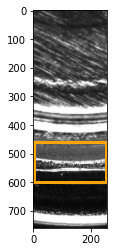

In [16]:
#plt.figure(figsize=(10,50))
plt.imshow(Image.open(os.path.join('C:/Users/yanzliu/Desktop/middle_bad', 'TG321090001HTP.jpg')))
plt.gca().add_patch(plt.Rectangle(xy=(1, 460), width=255-1, height=598-460, fill=False, linewidth=3, edgecolor='orange'))
#plt.gca().add_patch(plt.Rectangle(xy=(1737, 167), width=1865-1737, height=295-167, fill=False, linewidth=3, edgecolor='orange'))

In [17]:
xml_path = 'C:/Users/yanzliu/Desktop/middle_bad_xml'
xml_list = os.listdir(xml_path)

In [18]:
image_path = 'C:/Users/yanzliu/Desktop/middle_bad'

In [19]:
##制作数据集

class BatteryDataset(torch.utils.data.Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.annotations = [i for i in xml_list]
        self.imgs = [i[:-3] + 'jpg' for i in self.annotations]

    def __getitem__(self, idx):
        # load images ad annotations
        img_path = os.path.join(image_path, self.imgs[idx])
        label_path = os.path.join(xml_path, self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        # get bounding box coordinates
        boxes, annotation = parse_xml(file_xml=self.annotations[idx])
        num_objs = len(boxes)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [20]:
dataset = BatteryDataset()

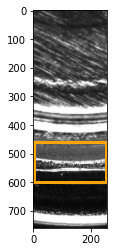

In [21]:
plt.imshow(dataset[0][0])
box_ = dataset[0][1]['boxes']
plt.gca().add_patch(plt.Rectangle(xy=(box_[0][0], box_[0][1]), width=box_[0][2]-box_[0][0], height=box_[0][3]-box_[0][1], fill=False, linewidth=3, edgecolor='orange'))

In [25]:
box_.shape

torch.Size([1, 4])

In [ ]:
### 检查一下dataset的数据标注
plt.figure(figsize=(40, 300)
    

In [27]:
### 检查一下dataset的数据标注
## plt.figure(figsize=(40, 300))
## for i in range(len(dataset)):
##            plt.subplot(11, 5, i+1)
##            plt.imshow(dataset[i][0])
##            box_ = dataset[i][1]['boxes']
##            if box_.shape[0] != 1:
##                plt.gca().add_patch(plt.Rectangle(xy=(box_[0][0], box_[0][1]), width=box_[0][2]-box_[0][0], height=box_[0][3]-box_[0][1], fill=False, linewidth=3, edgecolor='orange'))
##                plt.gca().add_patch(plt.Rectangle(xy=(box_[1][0], box_[1][1]), width=box_[1][2]-box_[1][0], height=box_[1][3]-box_[1][1], fill=False, linewidth=3, edgecolor='orange'))
##            else:
##                plt.gca().add_patch(plt.Rectangle(xy=(box_[0][0], box_[0][1]), width=box_[0][2]-box_[0][0], height=box_[0][3]-box_[0][1], fill=False, linewidth=3, edgecolor='orange'))
## plt.show()

### helper function for data argumentation

In [28]:
##加一个50%概率的水平翻转

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### putting everything together

In [29]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class frame
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [33]:
model = torch.load('C:/Users/yanzliu/Desktop/pytorch_model/f_rcnn_middle_v1.pkl')
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [34]:
# use our dataset and defined transformations
dataset = BatteryDataset(get_transform(train=True))
dataset_test = BatteryDataset(get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-5])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [34]:
# use our dataset and defined transformations
dataset = BatteryDataset(get_transform(train=True))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler_normal = torch.optim.lr_scheduler.StepLR(optimizer,
                                                      step_size=50,
                                                      gamma=0.1)

lr_scheduler_warmup = utils.warmup_lr_scheduler(optimizer,
                                                warmup_iters=1000,
                                                warmup_factor=1./1000)

num_epochs = 5

In [36]:
writer = SummaryWriter()

In [40]:
## 先做warmup
## 加一个early_stopping
iters = 0
best_test_loss = 100

for epoch in range(num_epochs):
    model.train()
    losses_train = 0
    for images, targets in data_loader:
        
        iters += 1
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        ##输出损失函数
        writer.add_scalar("Loss/train", losses, iters)
        loss_value = losses.item()
        print(f"Iteration #{iters} loss: {loss_value}")
        losses_train += loss_value

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if iters < 1000:
            lr_scheduler_warmup.step()
        else:
            lr_scheduler_normal.step()
    print('------------------------------------------------------------------')
    print(f"-----------Epoch #{epoch} train loss: {losses_train/ len(data_loader)}")
    ##  with torch.no_grad():
    ##      losses_test = 0
    ##      for images_, targets_ in data_loader_test:
    ##          images_ = list(image.to(device) for image in images_)
    ##          targets_ = [{k: v.to(device) for k,v in t.items()} for t in targets_]
    ##          
    ##          loss_dict_test = model(images, targets)
    ##          losses_test += sum(loss for loss in loss_dict_test.values())
    ##      losses_test = losses_test / len(data_loader_test)
    ##      writer.add_scalar("Loss/test", losses_test, epoch)
    ##      loss_value_test = losses_test.item()
    ##      print(f"-----------Epoch #{epoch} test loss: {loss_value_test}")
        ## early stopping
        ##if loss_value_test <= best_test_loss:
        ##    best_test_loss = loss_value_test
        ##    es=0
        ##else:
        ##    es+=1
        ##if es > 8:
        ##    break
        ##
writer.close()

Iteration #1 loss: 0.07592970132827759
Iteration #2 loss: 0.040398530662059784
Iteration #3 loss: 0.18011774122714996
Iteration #4 loss: 0.07094981521368027
Iteration #5 loss: 0.09950020164251328
Iteration #6 loss: 0.08630462735891342
Iteration #7 loss: 0.04432414472103119
Iteration #8 loss: 0.12235276401042938
Iteration #9 loss: 0.07937302440404892
Iteration #10 loss: 0.033214420080184937
Iteration #11 loss: 0.11993280053138733
Iteration #12 loss: 0.06782081723213196
Iteration #13 loss: 0.11567836999893188
Iteration #14 loss: 0.04704349860548973
Iteration #15 loss: 0.0758768618106842
Iteration #16 loss: 0.07409022748470306
Iteration #17 loss: 0.03666515275835991
Iteration #18 loss: 0.026924945414066315
Iteration #19 loss: 0.07658643275499344
Iteration #20 loss: 0.09741471707820892
Iteration #21 loss: 0.09280091524124146
Iteration #22 loss: 0.11492960900068283
Iteration #23 loss: 0.07033927738666534
Iteration #24 loss: 0.21241044998168945
Iteration #25 loss: 0.06996259838342667
-------

In [41]:
### 保存模型
##保存整个网络
torch.save(model, 'C:/Users/yanzliu/Desktop/pytorch_model/f_rcnn_middle_v2.pkl')

In [96]:
img,_ = dataset_test[2]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [101]:
#plt.figure(figsize=(20,10))
#plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
#rect_co = prediction[0]['boxes'].cpu().numpy()[0]
#x = rect_co[1]
#y = rect_co[0]
#width = rect_co[3] - rect_co[1]
#height = rect_co[2] - rect_co[0]
#plt.gca().add_patch(plt.Rectangle(xy=(y, x), width=height, height=width, fill=False, linewidth=4, edgecolor='orange'))

### test with 50 new images

In [41]:
test_path = 'C:/Users/yanzliu/Desktop/img_middle'

In [42]:
file_test = os.listdir(test_path)[-100:-50]

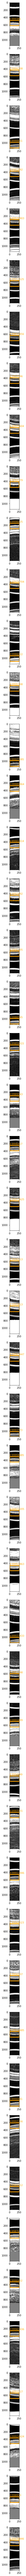

In [43]:
plt.figure(figsize=(20, 200))

for idx, file in enumerate(file_test):
    ## image转tensor
    file_array = np.array((Image.open(os.path.join(test_path, file))), dtype=np.float32)
    file_array /= 255.0
    file_torch = torch.from_numpy(np.transpose(file_array, (2,0,1)))
    
    ## prediction & plot
    model.eval()
    with torch.no_grad():
        prediction = model([file_torch.to(device)])
    
    plt.subplot(50, 1, idx+1)
    plt.imshow(file_array)
    bx = prediction[0]['boxes'].cpu().numpy().shape[0]
    for j in range(1):
        rect_co = prediction[0]['boxes'].cpu().numpy()[j]
        x = rect_co[1]
        y = rect_co[0]
        width = rect_co[3] - rect_co[1]
        height = rect_co[2] - rect_co[0]
        plt.gca().add_patch(plt.Rectangle(xy=(y, x), width=height, height=width, fill=False, linewidth=3, edgecolor='orange'))
        plt.text(y, x, prediction[0]['scores'].cpu().numpy()[j], color='orange',verticalalignment='bottom')

In [169]:
##prediction[0]['scores'].cpu().numpy()#[0]

In [168]:
##plt.figure(figsize=(20,10))
##plt.imshow(file_array)
##rect_co = prediction[0]['boxes'].cpu().numpy()[2]
##x = rect_co[1]
##y = rect_co[0]
##width = rect_co[3] - rect_co[1]
##height = rect_co[2] - rect_co[0]
##plt.gca().add_patch(plt.Rectangle(xy=(y, x), width=height, height=width, fill=False, linewidth=4, edgecolor='orange'))